In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle

## Tracking with Camshift

#### ROI

In [2]:
def selectROI(event,x,y,flags,params):
    global got_4_pints
    if len(roiPts)<4:
        if event == cv2.EVENT_LBUTTONDOWN:
            roiPts.append((x,y))
            # cv2.circle(frame, (x,y), 4, (0, 255, 0), 2)
    else:
        got_4_pints = True

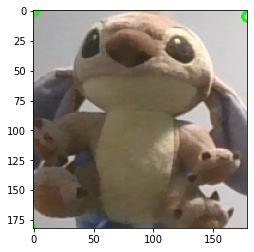

In [3]:
# # Capture video
# cap = cv2.VideoCapture(0)

# # # Take first frame (to define ROI)
# ret,frame = cap.read()
# roiPts=[]

# cv2.namedWindow('frame')
# cv2.setMouseCallback('frame',selectROI)
# got_4_pints=False
# while(1):
#     cv2.imshow('frame',frame)
#     k = cv2.waitKey(20) & 0xFF
#     if got_4_pints:
#         break

# cv2.waitKey(0)
# cv2.destroyAllWindows()

# # Save into pickle and frame
# cv2.imwrite("first_frame.jpg",frame)
# with open('roiPts.pickle', 'wb') as handle:
#     pickle.dump(roiPts, handle)


# Load ROI from pickle and first frame
with open('roiPts.pickle', 'rb') as handle:
    roiPts = pickle.load(handle)
frame = cv2.imread("first_frame.jpg")


x,y=roiPts[0]    # Upper left

h=roiPts[1][1]-y # Lower left

w=roiPts[2][0]-x # Upper right

track_window = (x, y, w, h) # Tracking window

# Select ROI
#--------------------------------------------------------------------------------------------
roi = frame[y:y+h, x:x+w]
plt.imshow(roi)


In [4]:
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV) # Convert ROI to HSV (H is more stable to changes in intensity)
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.))) # Mask for histogram (Hue: 0..180, Saturation:60..255, Value:32..255)
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180]) # Calculate histogram (only Hue: tonality)
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX); # Normalize histogram

#### Tracking loop

In [7]:
# Termination criteria: 10 iteration or move less than 1pt
#----------------------------------------------------------------
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 1, 10 )

cap = cv2.VideoCapture(0)

ROTATION = True

while(1):
    ret, frame = cap.read()
    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        
        ret, track_window = cv2.CamShift(dst, track_window, term_crit) # Apply camshift
        
        # Draw window
        if ROTATION:
            pts = cv2.boxPoints(ret)                      # Find the 4 vertices of rectangle
            pts = np.int0(pts)                            # int0 (for indexing)
            img2 = cv2.polylines(frame,[pts],True, 255,2) # Draw Rectanle
        else:
            x,y,w,h = track_window
            img2 = cv2.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        
        cv2.imshow('Seguimiento',img2)
        
        k = cv2.waitKey(30) & 0xff
        if k == 27:
            break
    else:
        break
cv2.destroyAllWindows()
cap.release()

### Related

- https://medium.com/@claudio.vindimian/understanding-and-implementing-the-camshift-object-tracking-algorithm-python-81587c24eda8